In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import json
import random
import seaborn as sns
import re

import spacy

# Text analysis
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SpanishStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('tokenizers/punkt/spanish.pickle')
nltk.download('stopwords')

import unicodedata

from wordcloud import WordCloud, STOPWORDS

# ### Scikit-Learn ###
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as skmetrics

from pyannote.audio.pipelines import VoiceActivityDetection

import analysis_utils as aute

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jllanes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading tokenizers/punkt/spanish.pickle: Package
[nltk_data]     'tokenizers/punkt/spanish.pickle' not found in index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jllanes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.


In [3]:
config_json = open("../LableniBotConfig/config.json")
config_dict = json.load(config_json)

hugging_face_key = config_dict["HUGGING_FACE"]

silence_detection_pipeline = VoiceActivityDetection(segmentation="pyannote/segmentation",
                                                    use_auth_token=hugging_face_key)

In [4]:
def get_audio_talk_duration(path_to_subj_conv):
    path_to_audios = path_to_subj_conv + "/Audios/"
    all_audios = os.listdir(path_to_audios)

    delta_talk_list = []
    for i_audio, audio in enumerate(all_audios):
        try:
            vad = silence_detection_pipeline(path_to_audios + audio)
        except:
            print("Bad audio", path_to_audios + audio)
            delta_talk_list.append(np.nan)

        seg_timeline = list(vad.get_timeline().segments_set_)
        
        if len(seg_timeline) > 0:
            start_time = np.min([seg.start for seg in seg_timeline])
            end_time = np.max([seg.end for seg in seg_timeline])

            delta_time_human_talk = end_time - start_time
            delta_talk_list.append(delta_time_human_talk)
        else:
            delta_talk_list.append(np.nan)
    
    return delta_talk_list

In [9]:
path_to_convs = "../Conversations/"
# all_df_list = []
for subj in os.listdir(path_to_convs):
    print(subj, end="\r")
    for file_subj in os.listdir(path_to_convs + subj):
        
        if file_subj + ".csv" in os.listdir("Results/PostProcessedData/"):
            continue
        
        if "." not in file_subj:
            path_to_subj_conv = path_to_convs + subj + "/" + file_subj
            all_csv_files = [file for file in os.listdir(path_to_subj_conv) if ".csv" in file]
            if len(all_csv_files) == 0:
                print("Bad subjects", path_to_subj_conv)
                continue 
                
            csv_name = all_csv_files[0]
            df_x = pd.read_csv(path_to_subj_conv + "/" + csv_name, sep=";")
            if df_x.shape[0] > 2:

                df_x["DeltaHumanTalk"] = np.nan
                delta_talk_list = get_audio_talk_duration(path_to_subj_conv)
                d_talk_nona_list = [t for t in delta_talk_list if not np.isnan(t)]
                source_person = df_x["Source"] == "Person"
                if np.sum(source_person) < len(d_talk_nona_list):
                    df_x.loc[source_person, "DeltaHumanTalk"] = d_talk_nona_list[:np.sum(source_person)]
                elif np.sum(source_person) == len(d_talk_nona_list):
                    df_x.loc[source_person, "DeltaHumanTalk"] = d_talk_nona_list
                else:
                    for _ in range(np.sum(source_person) - len(d_talk_nona_list)):
                        d_talk_nona_list.append(np.nan)
                    df_x.loc[source_person, "DeltaHumanTalk"] = d_talk_nona_list
                
                df_x.to_csv("Results/PostProcessedData/" + file_subj + ".csv", sep=";", index=False)
                
                # all_df_list.append(df_x)
'''
path_to_convs = "D:/GuardarDatosLableniBOT"

all_df_list = []
for subj in os.listdir(path_to_convs)[:]:
    if "User" in subj:
        print("Subject", subj, end="\r")
        path_to_conv_2 = path_to_convs + "/" + subj + "/" + subj + "_Conversations/"
        for file in os.listdir(path_to_conv_2):
            if "User" in file:
                path_to_subj_conv = path_to_conv_2 + file
                # try:
                csv_name = [file for file in os.listdir(path_to_subj_conv) if ".csv" in file][0]
                df_x = pd.read_csv(path_to_subj_conv + "/" + csv_name, sep=";")
                if df_x.shape[0] > 2:

                    df_x["DeltaHumanTalk"] = np.nan
                    delta_talk_list = get_audio_talk_duration(path_to_subj_conv)
                    d_talk_nona_list = [t for t in delta_talk_list if not np.isnan(t)]
                    source_person = df_x["Source"] == "Person"
                    if np.sum(source_person) < len(d_talk_nona_list):
                        df_x.loc[source_person, "DeltaHumanTalk"] = d_talk_nona_list[:np.sum(source_person)]
                    elif np.sum(source_person) == len(d_talk_nona_list):
                        df_x.loc[source_person, "DeltaHumanTalk"] = d_talk_nona_list
                    else:
                        for _ in range(np.sum(source_person) - len(d_talk_nona_list)):
                            d_talk_nona_list.append(np.nan)
                        df_x.loc[source_person, "DeltaHumanTalk"] = d_talk_nona_list

                    all_df_list.append(df_x)
                # except:
                    # print("Bad subject", path_to_subj_conv + "/" + csv_name)
'''

Bad audio ../Conversations/USER_01_CB2_Conversations/USER_01_CB2_20230131_101302/Audios/Subject_USER_01_CB2_T=9.wav
Bad audio ../Conversations/USER_01_CB2_Conversations/USER_01_CB2_20230131_103622/Audios/Subject_USER_01_CB2_T=6.wav
Bad audio ../Conversations/USER_01_CB2_Conversations/USER_01_CB2_20230131_104222/Audios/Subject_USER_01_CB2_T=9.wav
Bad audio ../Conversations/User_01_CB_Conversations/User_01_CB_20221116_100942/Audios/Subject_User_01_CB_T=8.wav
Bad audio ../Conversations/User_01_CB_Conversations/User_01_CB_20221116_101436/Audios/Subject_User_01_CB_T=5.wav
Bad audio ../Conversations/USER_02_CB2_Conversations/USER_02_CB2_20230131_121704/Audios/Subject_USER_02_CB2_T=5.wav
Bad audio ../Conversations/USER_02_CB2_Conversations/USER_02_CB2_20230131_122138/Audios/Subject_USER_02_CB2_T=11.wav
Bad audio ../Conversations/USER_03_CB2_Conversations/USER_03_CB2_20230131_140013/Audios/Subject_USER_03_CB2_T=7.wav
Bad audio ../Conversations/USER_03_CB2_Conversations/USER_03_CB2_20230131_140

Bad audio ../Conversations/User_30_CB_Conversations/User_30_CB_20221205_140607/Audios/Subject_User_30_CB_T=15.wav
Bad audio ../Conversations/User_30_CB_Conversations/User_30_CB_20221205_142235/Audios/Subject_User_30_CB_T=5.wav
Bad audio ../Conversations/USER_31_CB2_Conversations/USER_31_CB2_20230216_103212/Audios/Subject_USER_31_CB2_T=5.wav
Bad audio ../Conversations/USER_31_CB2_Conversations/USER_31_CB2_20230216_104535/Audios/Subject_USER_31_CB2_T=4.wav
Bad audio ../Conversations/USER_32_CB2_Conversations/USER_32_CB2_20230216_140515/Audios/Subject_USER_32_CB2_T=8.wav
Bad audio ../Conversations/USER_32_CB2_Conversations/USER_32_CB2_20230216_141458/Audios/Subject_USER_32_CB2_T=12.wav
Bad audio ../Conversations/User_32_CB_Conversations/User_32_CB_20221207_115042/Audios/Subject_User_32_CB_T=10.wav
Bad audio ../Conversations/User_32_CB_Conversations/User_32_CB_20221207_115814/Audios/Subject_User_32_CB_T=9.wav
Bad audio ../Conversations/User_32_CB_Conversations/User_32_CB_20221207_121214/Au

'\npath_to_convs = "D:/GuardarDatosLableniBOT"\n\nall_df_list = []\nfor subj in os.listdir(path_to_convs)[:]:\n    if "User" in subj:\n        print("Subject", subj, end="\r")\n        path_to_conv_2 = path_to_convs + "/" + subj + "/" + subj + "_Conversations/"\n        for file in os.listdir(path_to_conv_2):\n            if "User" in file:\n                path_to_subj_conv = path_to_conv_2 + file\n                # try:\n                csv_name = [file for file in os.listdir(path_to_subj_conv) if ".csv" in file][0]\n                df_x = pd.read_csv(path_to_subj_conv + "/" + csv_name, sep=";")\n                if df_x.shape[0] > 2:\n\n                    df_x["DeltaHumanTalk"] = np.nan\n                    delta_talk_list = get_audio_talk_duration(path_to_subj_conv)\n                    d_talk_nona_list = [t for t in delta_talk_list if not np.isnan(t)]\n                    source_person = df_x["Source"] == "Person"\n                    if np.sum(source_person) < len(d_talk_nona_lis

In [5]:
all_df_list = []
for file in os.listdir("Results/PostProcessedData/"):
    df_x = pd.read_csv("Results/PostProcessedData/" + file, sep=";")
    all_df_list.append(df_x)

In [6]:
result_process_data_list = []
for data in all_df_list:
    
    personality, gender, _ = data["ConfigName"].iloc[0].split("_")
    
    gender = "Female" if gender == "Woman" else gender
    gender = "Male" if gender == "Man" else gender
    
    human_time_talk = (data["PersonTalkEndUnix"] - data["PersonTalkStartUnix"]).dropna().values
    bot_time_talk = (data["BotTalkEndUnix"] - data["BotTalkStartUnix"]).dropna().values
    conv_time = (data["UnixTimeSave"].iloc[-1] - data["UnixTimestampLoopInit"].iloc[0])/60
    max_num_pair_sentence = 1 + np.max([
        label for label in data["ConversationSentenceId"].unique() if np.sum(data["ConversationSentenceId"] == label) == 2
    ])
    
    all_vh_text = data[data["Source"] == "Bot"]["SpanishMessage"].values
    num_words_vh = [len(re.findall(r'\w+', txt)) for txt in all_vh_text] 
    all_vh_text_big_str = " ; ".join(all_vh_text) 
    
    all_person_text = data[data["Source"] == "Person"]["SpanishMessage"].values
    num_words_person = [len(re.findall(r'\w+', txt)) for txt in all_person_text] 
    all_person_text_big_str = " ; ".join(all_person_text) 
    
    result_process_data_list.append({
        "SubjectId": data["SubjectId"].iloc[0],
        "VH_Name": data["ChatbotName"].iloc[0],
        "VH_Gender": gender,
        "VH_Personality": personality,
        "UnixLoopStart": data["UnixTimestampLoopInit"].iloc[0],
        "MeanHumanTime_s": np.mean(human_time_talk),
        "StdHumanTime_s": np.std(human_time_talk),
        "MaxHumanTime_s": np.max(human_time_talk),
        "FromAudio_MeanHumanTime_s": np.nanmean(data["DeltaHumanTalk"]),
        "FromAudio_StdHumanTime_s": np.nanstd(data["DeltaHumanTalk"]),
        "FromAudio_MaxHumanTime_s": np.nanmax(data["DeltaHumanTalk"]),
        "FromAudio_TotalHumanTime_s": np.nansum(data["DeltaHumanTalk"]),
        "MeanVHTime_s": np.mean(bot_time_talk),
        "StdVHTime_s": np.std(bot_time_talk),
        "MaxVHTime_s": np.max(bot_time_talk),
        "TotalVHTime_s": np.max(bot_time_talk),
        "ConvTime_min": conv_time,
        "NumberOfSentences": data.shape[0],
        "MaxNumQA": max_num_pair_sentence,
        "NumSentencePerson": np.sum(data["Source"] == "Person"),
        "NumSentenceVH": np.sum(data["Source"] == "Bot"),
        "TextPerson": all_person_text_big_str,
        "NumTotalWordsPerson": np.sum(num_words_person),
        "MeanWordsPerson": np.mean(num_words_person),
        "MaxWordsPerson": np.max(num_words_person),
        "StdWordsPerson": np.std(num_words_person),
        "TextVH": all_vh_text_big_str,
        "NumTotalWordsVH": np.sum(num_words_vh),
        "MeanWordsVH": np.mean(num_words_vh),
        "MaxWordsVH": np.max(num_words_vh),
        "StdWordsVH": np.std(num_words_vh)
    })
    
df_res_process = pd.DataFrame(result_process_data_list)

In [7]:
print(df_res_process.columns)
print("Shape", df_res_process.shape)
df_res_process.head(10)

Index(['SubjectId', 'VH_Name', 'VH_Gender', 'VH_Personality', 'UnixLoopStart',
       'MeanHumanTime_s', 'StdHumanTime_s', 'MaxHumanTime_s',
       'FromAudio_MeanHumanTime_s', 'FromAudio_StdHumanTime_s',
       'FromAudio_MaxHumanTime_s', 'FromAudio_TotalHumanTime_s',
       'MeanVHTime_s', 'StdVHTime_s', 'MaxVHTime_s', 'TotalVHTime_s',
       'ConvTime_min', 'NumberOfSentences', 'MaxNumQA', 'NumSentencePerson',
       'NumSentenceVH', 'TextPerson', 'NumTotalWordsPerson', 'MeanWordsPerson',
       'MaxWordsPerson', 'StdWordsPerson', 'TextVH', 'NumTotalWordsVH',
       'MeanWordsVH', 'MaxWordsVH', 'StdWordsVH'],
      dtype='object')
Shape (584, 31)


,SubjectId,VH_Name,VH_Gender,VH_Personality,UnixLoopStart,MeanHumanTime_s,StdHumanTime_s,MaxHumanTime_s,FromAudio_MeanHumanTime_s,FromAudio_StdHumanTime_s,...,TextPerson,NumTotalWordsPerson,MeanWordsPerson,MaxWordsPerson,StdWordsPerson,TextVH,NumTotalWordsVH,MeanWordsVH,MaxWordsVH,StdWordsVH
0,USER_01_CB2,Ana,Female,Neutral,1.675156e+09,9.592768,3.046409,15.713771,5.945273,3.151345,...,yo me llamo Sergio ; de Valencia España concre...,244,15.250000,26,8.287792,"Hola, mi nombre es Ana ¿Cómo te llamas tú? ; ¿...",86,5.375000,12,2.496873
1,USER_01_CB2,Alejandro,Male,Neutral,1.675156e+09,6.936624,1.312020,9.415424,3.451875,1.451536,...,Yo me llamo Sergio que también estás esperando...,87,9.666667,19,5.811865,"Hola, mi nombre es Alejandro ¿Cómo te llamas t...",100,10.000000,15,3.098387
2,USER_01_CB2,María,Female,Happy,1.675157e+09,7.502439,2.097531,12.588267,4.252500,3.130901,...,"Ya, yo soy Sergio qué haces por aquí? ; Voy, p...",135,13.500000,28,8.674676,"Encantada de conocerte, mi nombre es María ¿Cu...",163,16.300000,49,14.360014
3,USER_01_CB2,Jorge,Male,Angry,1.675157e+09,8.516293,2.223386,12.605755,5.281875,1.996983,...,Sergio y tú no si Jorge si te había escuchado....,119,17.000000,31,8.383658,"Mi nombre es Jorge ¿Cómo te llamas? ; Exacto, ...",198,28.285714,48,14.547600
4,USER_01_CB2,Lucía,Female,Relax,1.675158e+09,7.285726,2.354609,12.550632,3.957187,2.207698,...,"hola Lucía yo soy Sergio ; De Mislata y nada, ...",78,13.000000,30,8.850612,"Hola, mi nombre es Lucía ¿Cual es tu nombre? ;...",118,16.857143,42,11.293849
5,USER_01_CB2,Daniel,Male,Sad,1.675158e+09,8.719142,1.991105,12.594265,5.531250,2.365509,...,Hola Daniel yo soy Sergio qué haces por aquí. ...,143,15.888889,28,6.903211,"Hola, me llamo Daniel ¿y tú? ; Estoy sentado ...",115,11.500000,27,7.658329
6,User_01_CB,Laura,Female,Neutral,1.668588e+09,10.987555,5.116723,18.949747,6.252188,5.127379,...,"buenas yo soy Jesús ; yo sí, Valencia y tú ; P...",105,17.500000,44,15.019432,"Hola, mi nombre es Laura ¿Cómo te llamas tú? ;...",116,16.571429,37,10.265854
7,User_01_CB,David,Male,Neutral,1.668589e+09,7.830935,1.584070,9.427005,4.083750,2.342801,...,buenas yo soy Jesús ; Encantado mi deporte fav...,50,12.500000,23,6.873864,"Hola, mi nombre es David ¿Cómo te llamas tú? ;...",55,11.000000,16,2.607681
8,User_01_CB,María,Female,Happy,1.668589e+09,9.411009,3.463359,15.750861,4.752000,2.694755,...,hola buenas yo me llamo Jesús encantado María ...,66,13.200000,27,8.255907,"Encantada de conocerte, mi nombre es María ¿Cu...",101,20.200000,38,13.789851
9,User_01_CB,Pablo,Male,Relax,1.668589e+09,9.390276,3.389688,15.737232,5.351786,3.136928,...,"Hola, yo me llamo Jesús te gusta la playa, qué...",106,15.142857,24,6.854166,"Hola, mi nombre es Pablo ¿Cual es tu nombre? ;...",154,19.250000,41,9.443913


In [8]:
df_res_process["SubjectId"] = df_res_process["SubjectId"].replace("Alejandro", "User_10_CB")

In [9]:
print("Number of Subjects", df_res_process["SubjectId"].nunique())
print("Subjects", df_res_process["SubjectId"].unique())

Number of Subjects 98
Subjects ['USER_01_CB2' 'User_01_CB' 'USER_02_CB2' 'User_02_CB' 'USER_03_CB2'
 'User_03_CB' 'User_04_CB2' 'User_04_CB' 'User_05_CB2' 'User_05_CB'
 'USER_06_CB2' 'User_06_CB' 'USER_07_CB2' 'User_07_CB' 'USER_08_CB2'
 'User_08_CB' 'USER_09_CB2' 'User_09_CB' 'USER_10_CB2' 'User_10_CB'
 'USER_11_CB2' 'User_11_CB' 'USER_12_CB2' 'User_12_CB' 'USER_13_CB2'
 'User_13_CB' 'USER_14_CB2' 'User_14_CB' 'USER_15_CB2' 'User_15_CB'
 'USER_16_CB2' 'User_16_CB' 'USER_17_CB2' 'User_17_CB' 'USER_18_CB2'
 'User_18_CB' 'USER_19_CB2' 'User_19_CB' 'USER_20_CB2' 'User_20_CB'
 'USER_21_CB2' 'User_21_CB' 'USER_22_CB2' 'User_22_CB' 'USER_23_CB2'
 'User_23_CB' 'USER_24_CB2' 'User_24_CB' 'USER_25_CB2' 'User_25_CB'
 'USER_26_CB2' 'User_26_CB' 'USER_27_CB2' 'User_27_CB' 'USER_28_CB2'
 'User_28_CB' 'USER_29_CB2' 'User_29_CB' 'USER_30_CB2' 'User_30_CB'
 'USER_31_CB2' 'User_31_CB' 'USER_32_CB2' 'User_32_CB' 'USER_33_CB2'
 'User_33_CB' 'USER_34_CB2' 'User_34_CB' 'USER_35_CB2' 'User_35_CB'
 'USER_36_

In [10]:
df_res_process.to_csv("Results/DataConvProcessed.csv", sep=";", index=False)

In [11]:
df_res_process = pd.read_csv("Results/DataConvProcessed.csv", sep=";")

Mean FromAudio_MeanHumanTime_s = 4.2924 +/- 2.2815 ; Median = 3.8812 ; Min. =  0.9266 ; Max. =  15.0412
Mean MeanVHTime_s = 7.1695 +/- 1.8702 ; Median = 6.9078 ; Min. =  3.7716 ; Max. =  14.6599


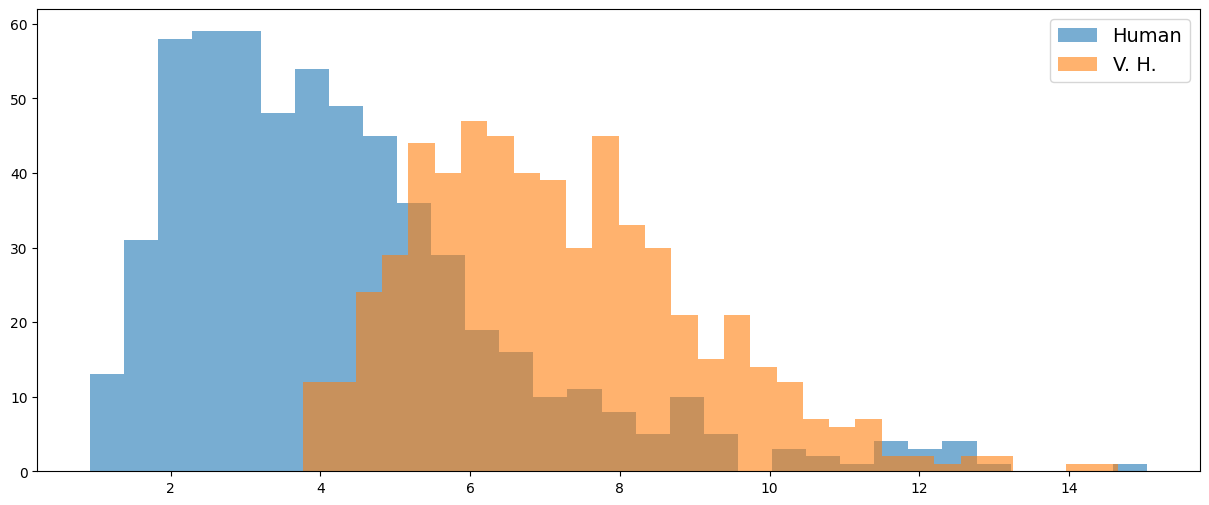

In [12]:
aute.stat_print(df_res_process["FromAudio_MeanHumanTime_s"], "FromAudio_MeanHumanTime_s")
aute.stat_print(df_res_process["MeanVHTime_s"], "MeanVHTime_s")

plt.figure(figsize=(15, 6))

plt.hist(df_res_process["FromAudio_MeanHumanTime_s"], bins=31, alpha=0.6, label="Human")
plt.hist(df_res_process["MeanVHTime_s"], bins=31, alpha=0.6, label="V. H.")
plt.legend(fontsize=14)

plt.show()

Mean NumSentencePerson = 10.1045 +/- 3.3085 ; Median = 10.0 ; Min. =  1 ; Max. =  19
Mean NumSentenceVH = 10.7397 +/- 3.1813 ; Median = 11.0 ; Min. =  2 ; Max. =  19


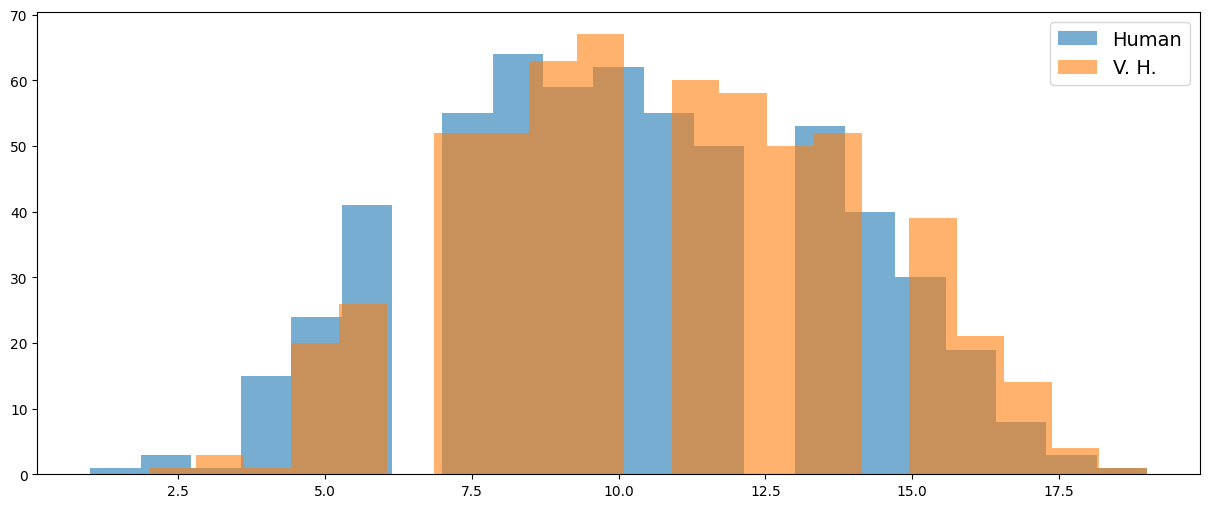

In [13]:
aute.stat_print(df_res_process["NumSentencePerson"], "NumSentencePerson")
aute.stat_print(df_res_process["NumSentenceVH"], "NumSentenceVH")

plt.figure(figsize=(15, 6))

plt.hist(df_res_process["NumSentencePerson"], bins=21, alpha=0.6, label="Human")
plt.hist(df_res_process["NumSentenceVH"], bins=21, alpha=0.6, label="V. H.")
plt.legend(fontsize=14)

plt.show()

Mean NumTotalWordsPerson = 110.2038 +/- 54.261 ; Median = 103.0 ; Min. =  5 ; Max. =  287
Mean NumTotalWordsVH = 137.2483 +/- 50.3984 ; Median = 134.0 ; Min. =  24 ; Max. =  295


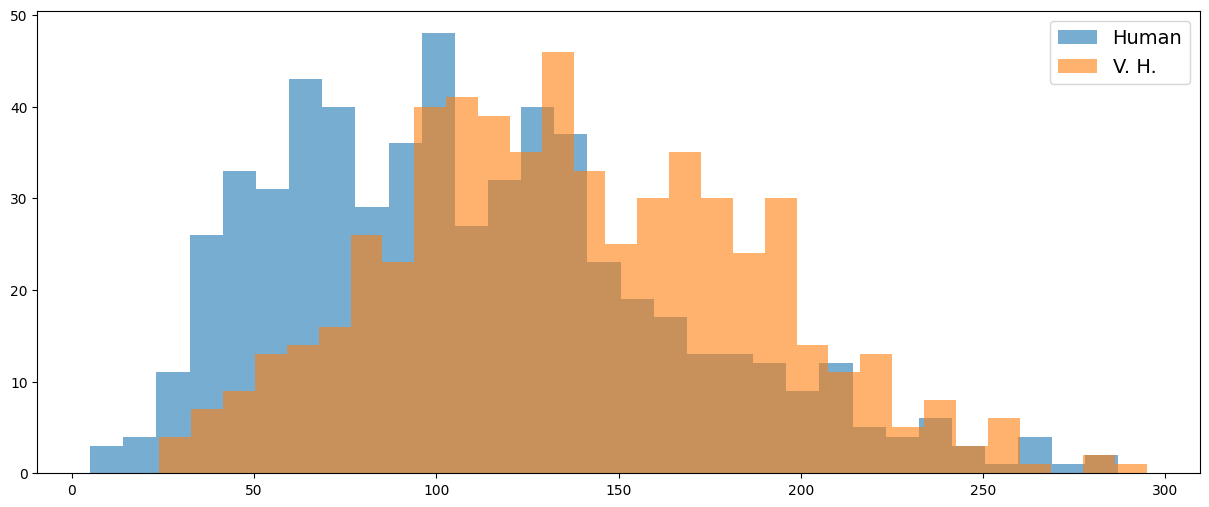

Mean MeanWordsPerson = 11.3418 +/- 5.6294 ; Median = 10.1538 ; Min. =  2.5 ; Max. =  35.375
Mean MeanWordsVH = 13.3441 +/- 5.1116 ; Median = 12.4 ; Min. =  4.1429 ; Max. =  33.5714


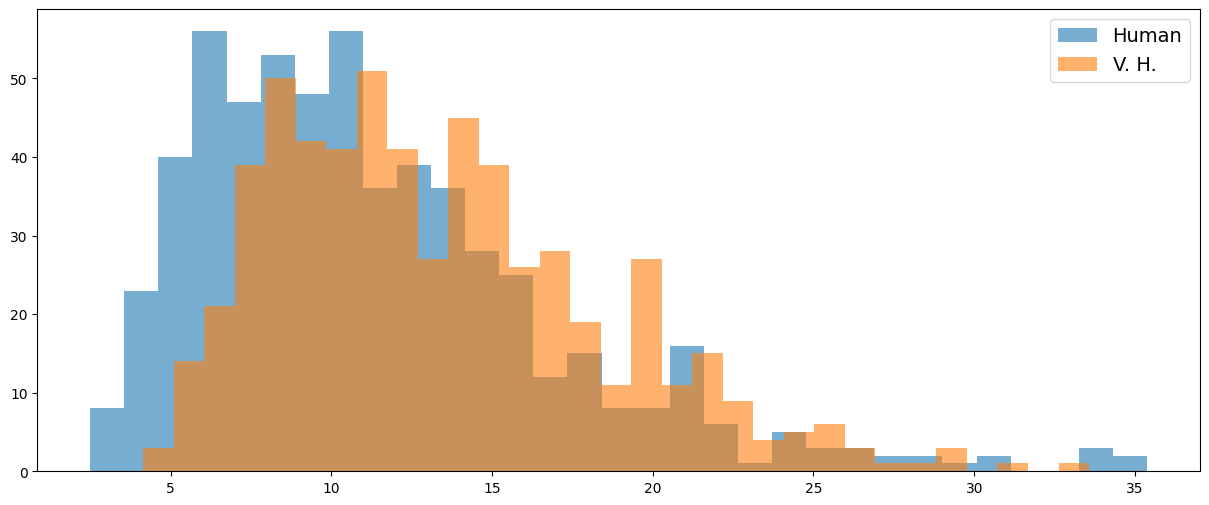

In [14]:
aute.stat_print(df_res_process["NumTotalWordsPerson"], "NumTotalWordsPerson")
aute.stat_print(df_res_process["NumTotalWordsVH"], "NumTotalWordsVH")

plt.figure(figsize=(15, 6))

plt.hist(df_res_process["NumTotalWordsPerson"], bins=31, alpha=0.6, label="Human")
plt.hist(df_res_process["NumTotalWordsVH"], bins=31, alpha=0.6, label="V. H.")
plt.legend(fontsize=14)

plt.show()

aute.stat_print(df_res_process["MeanWordsPerson"], "MeanWordsPerson")
aute.stat_print(df_res_process["MeanWordsVH"], "MeanWordsVH")

plt.figure(figsize=(15, 6))

plt.hist(df_res_process["MeanWordsPerson"], bins=31, alpha=0.6, label="Human")
plt.hist(df_res_process["MeanWordsVH"], bins=31, alpha=0.6, label="V. H.")
plt.legend(fontsize=14)

plt.show()